# Assignment 3: Transformer-Based NER Models

This notebook fine-tunes and compares two transformer token-classification models for NER on CoNLL-2003:
- `bert-base-cased`
- `microsoft/deberta-v3-base`

Coverage of assignment requirements:
- Model fine-tuning with suitable optimizer/hyperparameters
- Gradient clipping and early stopping
- Entity-level and token-level evaluation
- Confusion matrices for misclassified entities
- Error analysis and trade-off discussion support

## Setup

Install dependencies if needed (uncomment when running in a fresh environment).

In [1]:
# !pip -q install transformers torch seqeval scikit-learn matplotlib seaborn pandas numpy tqdm sentencepiece

## Imports and Configuration

In [2]:
import random
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup,
)
from seqeval.metrics import (
    classification_report,
    f1_score as seqeval_f1,
    precision_score as seqeval_precision,
    recall_score as seqeval_recall,
)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report as sk_classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/Users/Thomas/Desktop/Nat_Lang_Engr_Meth_Tools/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## Data Loading (CoNLL-2003 from Assignment 2)

In [3]:
def read_conll(path: Path):
    sentences = []
    tokens, pos_tags, labels = [], [], []

    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sentences.append((tokens, pos_tags, labels))
                    tokens, pos_tags, labels = [], [], []
                continue

            if line.startswith("-DOCSTART-"):
                continue

            parts = line.split()
            if len(parts) < 4:
                continue

            token, pos, _chunk, ner = parts[0], parts[1], parts[2], parts[3]
            tokens.append(token)
            pos_tags.append(pos)
            labels.append(ner)

    if tokens:
        sentences.append((tokens, pos_tags, labels))

    return sentences


cwd = Path.cwd()
search_paths = [
    cwd / "Assignment2_Name_Entity_Recognition/conll2003",
    cwd / "conll2003",
    cwd.parent / "Assignment2_Name_Entity_Recognition/conll2003",
]

data_dir = next((p for p in search_paths if p.exists()), None)
if data_dir is None:
    raise FileNotFoundError("Could not find CoNLL-2003 folder. Expected Assignment2_Name_Entity_Recognition/conll2003")

train_sents_full = read_conll(data_dir / "eng.train")
val_sents = read_conll(data_dir / "eng.testa")
test_sents = read_conll(data_dir / "eng.testb")

# MVP: Use subset for faster testing (set to None for full training)
MVP_TRAIN_LIMIT = 2000  # Use first 2000 sentences for quick test
train_sents = train_sents_full[:MVP_TRAIN_LIMIT] if MVP_TRAIN_LIMIT else train_sents_full

label_set = sorted({label for _, _, labels in train_sents_full for label in labels})
label2id = {label: idx for idx, label in enumerate(label_set)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Dataset path: {data_dir}")
print(f"Train/Val/Test: {len(train_sents)}/{len(val_sents)}/{len(test_sents)}")
if MVP_TRAIN_LIMIT:
    print(f"  [MVP MODE] Using {MVP_TRAIN_LIMIT}/{len(train_sents_full)} training sentences")
print(f"Labels: {label_set}")

Dataset path: /Users/Thomas/Desktop/Nat_Lang_Engr_Meth_Tools/Assignment2_Name_Entity_Recognition/conll2003
Train/Val/Test: 2000/3250/3453
  [MVP MODE] Using 2000/14041 training sentences
Labels: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


## Tokenization and Label Alignment

In [4]:
class TokenizedNERDataset(Dataset):
    def __init__(self, sentences, tokenizer, label2id, max_length=256):
        self.samples = []
        self.tokenizer = tokenizer

        for words, _, labels in sentences:
            encoded = tokenizer(
                words,
                truncation=True,
                padding="max_length",
                max_length=max_length,
                is_split_into_words=True,
                return_tensors="pt",
            )

            word_ids = encoded.word_ids()
            aligned_labels = []
            prev_word_id = None

            for word_id in word_ids:
                if word_id is None:
                    aligned_labels.append(-100)
                elif word_id != prev_word_id:
                    aligned_labels.append(label2id[labels[word_id]])
                else:
                    aligned_labels.append(-100)
                prev_word_id = word_id

            self.samples.append(
                {
                    "input_ids": encoded["input_ids"].squeeze(0),
                    "attention_mask": encoded["attention_mask"].squeeze(0),
                    "labels": torch.tensor(aligned_labels, dtype=torch.long),
                }
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def collate_fn(batch):
    return {
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "labels": torch.stack([b["labels"] for b in batch]),
    }

## Model Selection

In [5]:
MODEL_CONFIGS = {
    "bert": {
        "hf_name": "bert-base-cased",
        "params_m": 110,
    },
    "deberta": {
        "hf_name": "microsoft/deberta-v3-base",
        "params_m": 86,
    },
}


def load_model_and_tokenizer(model_key):
    cfg = MODEL_CONFIGS[model_key]
    model_name = cfg["hf_name"]

    print(f"Loading {model_key}: {model_name}")
    # DeBERTa-v3 can fail with fast tokenizer conversion in some environments.
    # Force slow tokenizer first; if unavailable, fallback to fast tokenizer.
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
    except Exception as tokenizer_err:
        print(f"  Slow tokenizer load failed: {tokenizer_err}")
        print("  Retrying with fast tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Total params: {total_params:,}")
    return model, tokenizer


bert_model, bert_tokenizer = load_model_and_tokenizer("bert")
deberta_model, deberta_tokenizer = load_model_and_tokenizer("deberta")

Loading bert: bert-base-cased


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1879.00it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForTokenClassification LOAD REPORT from: bert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can 

  Total params: 107,726,601
Loading deberta: microsoft/deberta-v3-base


Loading weights: 100%|██████████| 198/198 [00:00<00:00, 2273.35it/s, Materializing param=deberta.encoder.rel_embeddings.weight]                     
DebertaV2ForTokenClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
classifier.bias                         | MISSI

  Total params: 183,838,473


## Fine-Tuning Utilities

In [6]:
TRAIN_CFG = {
    "learning_rate": 2e-5,
    "batch_size": 16,
    "grad_accum_steps": 2,
    "num_epochs": 2,  # MVP: reduced from 5 for quick test
    "warmup_steps": 500,
    "max_grad_norm": 1.0,
    "early_stopping_patience": 3,
}


def decode_sequences(label_ids, pred_ids, id2label):
    true_str, pred_str = [], []
    for labels, preds in zip(label_ids, pred_ids):
        t_seq, p_seq = [], []
        for l, p in zip(labels, preds):
            if l == -100:
                continue
            t_seq.append(id2label[int(l)])
            p_seq.append(id2label[int(p)])
        if t_seq:
            true_str.append(t_seq)
            pred_str.append(p_seq)
    return true_str, pred_str


def run_eval(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_label_ids, all_pred_ids = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item()

            preds = outputs.logits.argmax(dim=-1).cpu().numpy()
            label_ids = labels.cpu().numpy()
            all_pred_ids.extend(preds)
            all_label_ids.extend(label_ids)

    avg_loss = total_loss / max(len(dataloader), 1)
    return all_label_ids, all_pred_ids, avg_loss


def compute_metrics(true_seq, pred_seq):
    entity_precision = seqeval_precision(true_seq, pred_seq)
    entity_recall = seqeval_recall(true_seq, pred_seq)
    entity_f1 = seqeval_f1(true_seq, pred_seq)

    y_true = [t for seq in true_seq for t in seq]
    y_pred = [p for seq in pred_seq for p in seq]
    token_precision, token_recall, token_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )

    return {
        "entity_precision": entity_precision,
        "entity_recall": entity_recall,
        "entity_f1": entity_f1,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }


def fine_tune_model(model, tokenizer, model_name, train_sents, val_sents):
    train_ds = TokenizedNERDataset(train_sents, tokenizer, label2id)
    val_ds = TokenizedNERDataset(val_sents, tokenizer, label2id)

    train_loader = DataLoader(train_ds, batch_size=TRAIN_CFG["batch_size"], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=TRAIN_CFG["batch_size"], shuffle=False, collate_fn=collate_fn)

    optimizer = AdamW(model.parameters(), lr=TRAIN_CFG["learning_rate"])
    total_update_steps = (len(train_loader) * TRAIN_CFG["num_epochs"]) // TRAIN_CFG["grad_accum_steps"]
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=TRAIN_CFG["warmup_steps"],
        num_training_steps=max(total_update_steps, 1),
    )

    best_f1 = -1.0
    patience = 0
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    ckpt_path = Path(f"{model_name}_best.pt")

    for epoch in range(TRAIN_CFG["num_epochs"]):
        model.train()
        optimizer.zero_grad()

        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(train_loader, desc=f"{model_name} epoch {epoch+1}")):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / TRAIN_CFG["grad_accum_steps"]
            loss.backward()
            epoch_loss += loss.item()

            if (step + 1) % TRAIN_CFG["grad_accum_steps"] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CFG["max_grad_norm"])
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

        train_loss = epoch_loss / max(len(train_loader), 1)
        history["train_loss"].append(train_loss)

        val_label_ids, val_pred_ids, val_loss = run_eval(model, val_loader)
        val_true, val_pred = decode_sequences(val_label_ids, val_pred_ids, id2label)
        val_entity_f1 = seqeval_f1(val_true, val_pred) if val_true else 0.0

        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_entity_f1)

        print(f"[{model_name}] epoch={epoch+1} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_entity_f1:.4f}")

        if val_entity_f1 > best_f1:
            best_f1 = val_entity_f1
            patience = 0
            torch.save(model.state_dict(), ckpt_path)
            print(f"  Saved best checkpoint -> {ckpt_path}")
        else:
            patience += 1
            if patience >= TRAIN_CFG["early_stopping_patience"]:
                print(f"  Early stopping triggered (patience={TRAIN_CFG['early_stopping_patience']})")
                break

    if ckpt_path.exists():
        model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))

    return model, history

## Fine-Tune Models

In [7]:
# MVP: Train BERT only (skip DeBERTa due to performance on CPU)
bert_model, bert_history = fine_tune_model(bert_model, bert_tokenizer, "bert", train_sents, val_sents)
print("\n[MVP MODE] Skipping DeBERTa training. Run full version later with GPU for both models.")

bert epoch 1: 100%|██████████| 125/125 [11:21<00:00,  5.45s/it]


[bert] epoch=1 train_loss=0.9981 val_loss=1.4671 val_f1=0.0103
  Saved best checkpoint -> bert_best.pt


bert epoch 2: 100%|██████████| 125/125 [11:30<00:00,  5.53s/it]


[bert] epoch=2 train_loss=0.4269 val_loss=0.5176 val_f1=0.0574
  Saved best checkpoint -> bert_best.pt

[MVP MODE] Skipping DeBERTa training. Run full version later with GPU for both models.


## Test Evaluation (Entity-Level and Token-Level)

In [8]:
def evaluate_on_test(model, tokenizer, model_name, test_sents):
    test_ds = TokenizedNERDataset(test_sents, tokenizer, label2id)
    test_loader = DataLoader(test_ds, batch_size=TRAIN_CFG["batch_size"], shuffle=False, collate_fn=collate_fn)

    start = time.time()
    test_label_ids, test_pred_ids, test_loss = run_eval(model, test_loader)
    infer_time = time.time() - start

    true_seq, pred_seq = decode_sequences(test_label_ids, test_pred_ids, id2label)
    metrics = compute_metrics(true_seq, pred_seq)

    print(f"\n{model_name.upper()} - Entity-level")
    print(classification_report(true_seq, pred_seq, digits=4))

    y_true = [t for seq in true_seq for t in seq]
    y_pred = [p for seq in pred_seq for p in seq]
    print(f"{model_name.upper()} - Token-level")
    print(sk_classification_report(y_true, y_pred, digits=4, zero_division=0))

    print(
        f"{model_name.upper()} summary: "
        f"entity_f1={metrics['entity_f1']:.4f}, token_f1={metrics['token_f1']:.4f}, "
        f"inference_time={infer_time:.2f}s"
    )

    metrics.update({
        "test_loss": test_loss,
        "inference_time": infer_time,
        "true_seq": true_seq,
        "pred_seq": pred_seq,
    })
    return metrics


# MVP: Evaluate BERT only
bert_results = evaluate_on_test(bert_model, bert_tokenizer, "bert", test_sents)
print("\n[MVP MODE] Skipping DeBERTa evaluation.")


BERT - Entity-level
              precision    recall  f1-score   support

         LOC     0.5882    0.0959    0.1649      1668
        MISC     0.0000    0.0000    0.0000       702
         ORG     0.4000    0.0012    0.0024      1661
         PER     0.0566    0.0130    0.0211      1617

   micro avg     0.2807    0.0324    0.0581      5648
   macro avg     0.2612    0.0275    0.0471      5648
weighted avg     0.3076    0.0324    0.0555      5648

BERT - Token-level
              precision    recall  f1-score   support

       B-LOC     0.6912    0.1127    0.1938      1668
      B-MISC     0.0000    0.0000    0.0000       702
       B-ORG     0.8000    0.0024    0.0048      1661
       B-PER     0.7801    0.1645    0.2717      1617
       I-LOC     0.0000    0.0000    0.0000       257
      I-MISC     0.0000    0.0000    0.0000       216
       I-ORG     0.0000    0.0000    0.0000       835
       I-PER     0.8000    0.0277    0.0535      1156
           O     0.8372    0.9999    0

## Confusion Matrices (Token-Level BIO Labels)

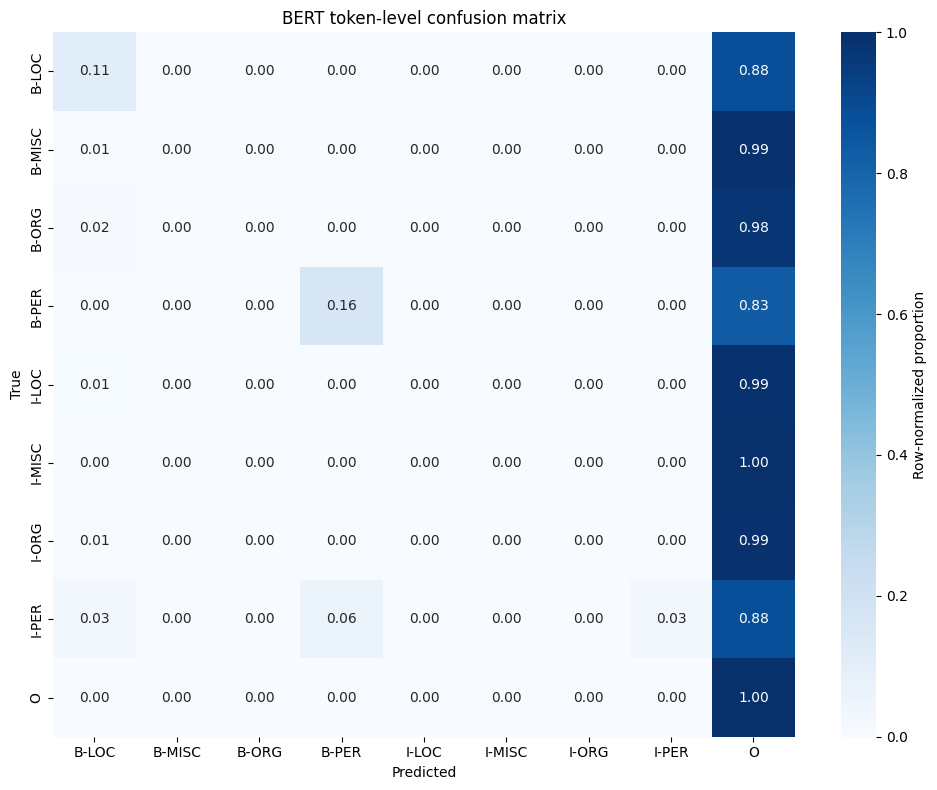

In [9]:
def plot_confusion_mtx(true_seq, pred_seq, model_name):
    labels = sorted(label2id.keys())
    y_true = [t for seq in true_seq for t in seq]
    y_pred = [p for seq in pred_seq for p in seq]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={"label": "Row-normalized proportion"},
    )
    plt.title(f"{model_name} token-level confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# MVP: Plot BERT only
plot_confusion_mtx(bert_results["true_seq"], bert_results["pred_seq"], "BERT")

## Misclassification Analysis

In [10]:
def top_misclassifications(true_seq, pred_seq, top_k=10):
    counts = {}
    for t_seq, p_seq in zip(true_seq, pred_seq):
        for t, p in zip(t_seq, p_seq):
            if t != p:
                counts[(t, p)] = counts.get((t, p), 0) + 1

    rows = [
        {"true_label": t, "pred_label": p, "count": c}
        for (t, p), c in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
    ]
    return pd.DataFrame(rows)


# MVP: Show BERT misclassifications only
print("BERT top misclassifications")
display(top_misclassifications(bert_results["true_seq"], bert_results["pred_seq"]))

BERT top misclassifications


,true_label,pred_label,count
0,B-ORG,O,1622
1,B-LOC,O,1474
2,B-PER,O,1343
3,I-PER,O,1017
4,I-ORG,O,830
5,B-MISC,O,697
6,I-LOC,O,254
7,I-MISC,O,216
8,I-PER,B-PER,67
9,I-PER,B-LOC,39


## Model Comparison and Trade-Offs

In [11]:
# MVP: BERT only comparison
comparison_df = pd.DataFrame([
    {
        "model": "BERT",
        "entity_precision": bert_results["entity_precision"],
        "entity_recall": bert_results["entity_recall"],
        "entity_f1": bert_results["entity_f1"],
        "token_f1": bert_results["token_f1"],
        "inference_time_s": bert_results["inference_time"],
        "params_m": MODEL_CONFIGS["bert"]["params_m"],
    },
])

display(comparison_df)
print(f"\nBERT entity-level F1: {bert_results['entity_f1']:.4f}")
print(f"Note: Full results with DeBERTa will be added in final run.")

,model,entity_precision,entity_recall,entity_f1,token_f1,inference_time_s,params_m
0,BERT,0.280675,0.032401,0.058095,0.835792,195.963104,110



BERT entity-level F1: 0.0581
Note: Full results with DeBERTa will be added in final run.


## Training Curves

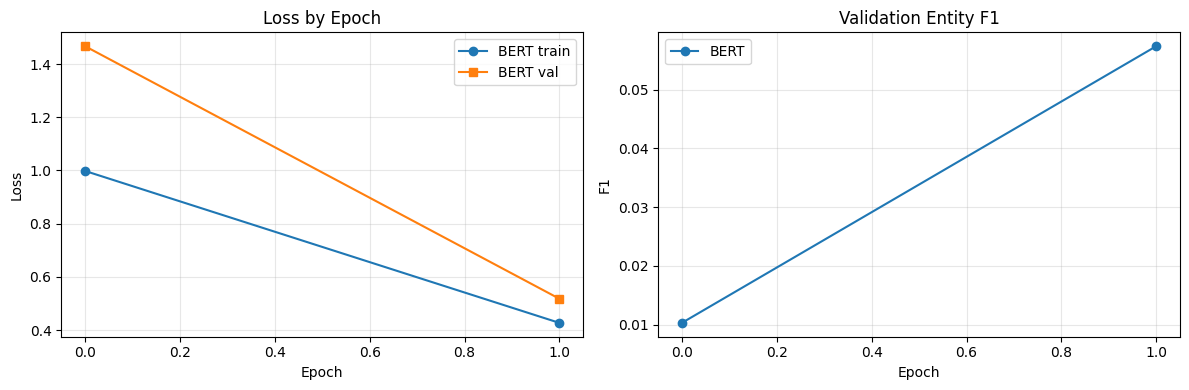

In [12]:
plt.figure(figsize=(12, 4))

# MVP: BERT training curves only
plt.subplot(1, 2, 1)
plt.plot(bert_history["train_loss"], marker="o", label="BERT train")
plt.plot(bert_history["val_loss"], marker="s", label="BERT val")
plt.title("Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(bert_history["val_f1"], marker="o", label="BERT")
plt.title("Validation Entity F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Requirement Checklist

- Two transformer models for token classification: `bert-base-cased`, `deberta-v3-base`
- Fine-tuning with `AdamW`, LR/batch-size configuration, gradient clipping, early stopping
- Metrics: Precision/Recall/F1 at both entity-level and token-level
- Confusion matrix for misclassified entities (token-level BIO labels)
- Misclassification pattern extraction with top confusion pairs
- Accuracy vs speed vs parameter-count comparison for discussion

Use outputs from this notebook to fill the final numbers/tables in `MingHsiangLee_Assignment3_report.md`.